In [2]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from matplotlib import pyplot as plt
%matplotlib qt 

In [3]:
"""
***Aestetics***
"""
# load color palette
my_palette = sns.color_palette().as_hex()
sns.color_palette().as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [4]:
"""
load all files like for real
"""

folder_path = f"C:/Users/mvmigem/Documents/data/project_1/overlap_corrected/"
full_folder_list = glob.glob(folder_path+"*")[:64]

# Load like the first electrode path to do stuf with
el_1_dir_list = glob.glob(full_folder_list[0]+'/*.csv')
# Make a sub list
excuded_pp = [3,14,20]
subject_list = []
excluded_path_list = []

# Creat a base df to which we append the others
for i in el_1_dir_list:
    sub = int(i.split(f'corrected_AF3_evoked_')[1].split('.csv')[0])
    if sub not in excuded_pp:
        subject_list.append(sub)
        excluded_path_list.append(i)

sub_el1_list = []
el_base_path = folder_path + 'AF3'
for sub_el1 in excluded_path_list:
    df1 = pd.read_csv(sub_el1)
    sub_el1_list.append(df1)

df_base = pd.concat(sub_el1_list,ignore_index=True)
df_el = df_base['selected_electrode'][0]
df_base.rename(columns={'yhat':df_el},inplace=True)
df_base = df_base.drop('selected_electrode', axis=1)

# Now for all dfs

for i, el_path in enumerate(full_folder_list[1:64]): #for ful folder except the var electrodes files
    df_el = el_path.rstrip("/").split("\\")[-1]
    sub_el_list = []
    for sub in subject_list:
        df_path = el_path + f'/corrected_{df_el}_evoked_{sub:02}.csv'
        df = pd.read_csv(df_path)
        sub_el_list.append(df)
    df_n = pd.concat(sub_el_list,ignore_index=True)
    df_base[df_el] = df_n['yhat']


In [5]:
""" 
Make visual field and set eeg stuff up
"""
# Make the updwon col
df_base['visual_field'] = np.where(df_base['position'].isin([1,2]),'up','down')

# Load the 10-20 montage
montage = mne.channels.make_standard_montage('biosemi64')
# Get the list of channel names
electrode_names = montage.ch_names
sfreq = 512


In [6]:
""" 
create mne evoked objects from df
"""

evoked_att_reg = []
evoked_att_odd = []
evoked_unatt_reg = []
evoked_unatt_odd = []

evoked_up = []
evoked_down = []

evoked_all = []

listed = [evoked_att_reg,evoked_att_odd,evoked_unatt_reg,evoked_unatt_odd,evoked_up,evoked_down,evoked_all]

for sub in subject_list:
    df_s = df_base[df_base['subject'] == sub]
    info = mne.create_info(ch_names = electrode_names,sfreq = sfreq, ch_types='eeg')
    # for the experimental condditions
    df_at_re = df_s[(df_s['attention'] == 'attended') & (df_s['expectation'] == 'regular')].groupby('time')[electrode_names].mean()
    df_at_od = df_s[(df_s['attention'] == 'attended') & (df_s['expectation'] == 'odd')].groupby('time')[electrode_names].mean()
    df_un_re = df_s[(df_s['attention'] == 'unattended') & (df_s['expectation'] == 'regular')].groupby('time')[electrode_names].mean()
    df_un_od = df_s[(df_s['attention'] == 'unattended') & (df_s['expectation'] == 'odd')].groupby('time')[electrode_names].mean()
    # for visual_field
    df_up = df_s[df_s['visual_field'] == 'up'].groupby('time')[electrode_names].mean()
    df_down = df_s[df_s['visual_field'] == 'down'].groupby('time')[electrode_names].mean()
    # all conditions
    df_all = df_s.groupby('time')[electrode_names].mean()

    times = df_at_re.index
    df_listed = [df_at_re,df_at_od,df_un_re,df_un_od,df_up,df_down,df_all]
    for df,ev_list in zip(df_listed,listed):
        data = df.to_numpy().T * 1e-6
        ev = mne.EvokedArray(data=data,info= info, tmin = times[0]) 
        ev.set_montage(montage)
        ev.apply_baseline()
        ev_list.append(ev)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

In [10]:
""" 
Grand averages
"""
ga_att_reg = mne.grand_average(evoked_att_reg)
ga_att_odd = mne.grand_average(evoked_att_odd)
ga_unatt_reg = mne.grand_average(evoked_unatt_reg) 
ga_unatt_odd = mne.grand_average(evoked_unatt_odd)

ga_up = mne.grand_average(evoked_up)
ga_down = mne.grand_average(evoked_down)

ga_all = mne.grand_average(evoked_all)

Identifying common channels ...


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


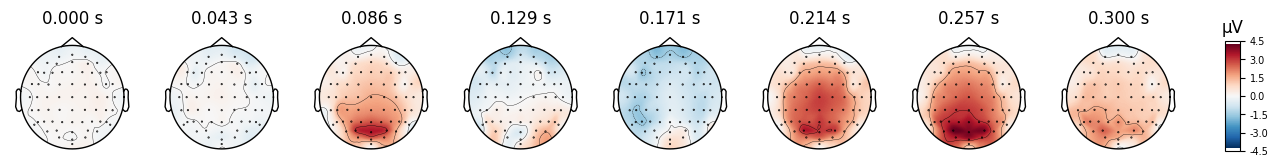

In [7]:
tim = np.linspace(0, 0.3, 1)
ga_att_reg.plot_topomap(ch_type="eeg", times=tim, colorbar=True)
ga_att_odd.plot_topomap(ch_type="eeg", times=tim, colorbar=True)
ga_unatt_reg.plot_topomap(ch_type="eeg", times= tim, colorbar=True)
ga_unatt_odd.plot_topomap(ch_type="eeg", times= tim, colorbar=True)
ga_up.plot_topomap(ch_type="eeg", times= tim, colorbar=True)
ga_down.plot_topomap(ch_type="eeg", times= tim, colorbar=True)

In [1]:
tim = np.linspace(0.089, 0.1, 1)
ga_up.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=(-2.5,2.5))

NameError: name 'np' is not defined